## Sentiment Analysis on  [Sentiment140](http://help.sentiment140.com/for-students). 
Sentiment140 is an automatically retrieved and sentiment tagged dataset from Twitter. The dataset was created by [Go et al.](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf) and uses emoticons to automatically classify the sentiment in a tweet and therefore provides a resource of 1.600.000 polarity annotated tweets. In the following we implemented a neural network trained on a subset of these tweets aiming to correctly identify its polarity. For this task we used  the [ConceptNet](https://github.com/commonsense/conceptnet) word embedding vectors to represent our tweets numerically in a semantic concept space. 

**Imports**

In [13]:
import os
import random

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import nltk

**Functions**

In [14]:
def read_in(path_to_file):
    """
    Reads in training and test data and removes all neutral tweets
    from test data because the training data lacks neutral.
    Due to hardware restrictions we used only 1/10th of the available 
    training dataset (160.000 tweets)
    """
    out = []
    with open(path_to_file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if not row[0] == "2":
                out.append([row[0], row[5]])
        random.shuffle(out)
    return out[:150000]


def preprocess(data):
    """
    Preprocesses and tokenizes data
    """
    label = []
    tweet = []
    print("Preprocessing...")
    for row in data:
        cleaned = clean_regex(row[1].lower())
        if cleaned.__len__() > 1:
            if row[0] == "0":
                label.append(0)
            else:
                label.append(1)
            tokenized = nltk.word_tokenize(cleaned)
            # pos_tagged = nltk.pos_tag(tokenized)
            tweet.append(tokenized)
    print("Done")
    return tweet, label


def clean_regex(tweet):
    """
    Regex that removes links to other users, and all hyperlink mentions
    """
    cleaned = re.sub('@.*?(?:\s|$)', '', tweet)
    cleaned2 = re.sub('http.*?(?:\s|$)', '', cleaned)
    cleaned3 = re.sub('www.*?(?:\s|$)', '', cleaned2)
    return cleaned3

def parse_to_dict(file_path):
    """
    Creates hashmap with word as key and concept vector as value
    :param file_path: path to the conceptnet dictionary file
    :return: hashmap of word and vectors
    """
    concept_hash = {}
    with open(file_path, encoding="utf8") as f:
        text = f.readlines()[1:]
        for line in text:
            first_item = line.split(" ").__getitem__(0)
            concept_hash[first_item] = line
    f.close()
    return concept_hash

def find_word(word, concept_hash):
    """
    Finds conceptnet vector for a word in the conceptnet hashmap
    :param word: input word to analyze
    :param concept_hash: hashmap of word and conceptnet vector
    :return: returns the appropriate vector or none if its not in the hashmap
    """
    if word in concept_hash.keys():
        vector = concept_hash[word].split(" ")[1:]
        vector = [float(i) for i in vector]
    else:
        vector = None
    return vector
  
def get_embeddings(sentences):
    """
    Retrieves a 300 dim. embedding vector from ConceptNet for each word 
    of a sentence. (Only retrieves the first 35 words (tokens) of a tweet)
    """
    max_words = 35
    results = np.zeros((len(sentences), max_words, 300))
    for i, sent in enumerate(sentences):
        if i % 25000 == 0:
            print(str(i))
        for j, word in enumerate(sent):
            if j < max_words:
                embedding = find_word(word.lower(), concept_hash)
                if embedding is not None:
                    for k, val in enumerate(embedding):
                        results[i][j][k] = val
                else:
                    for k in range(300):
                        results[i][j][k] = 0.0
    return results




**Preprocessing**

In [15]:
print(os.getcwd())
#base_path = "C:/Users/Tobias.Nusser/PycharmProjects/sentiment_learning"
base_path = os.getcwd()
# 140.000 entries
training_data, training_label = preprocess(read_in(base_path + "/data/training.csv"))
test_data, test_label = preprocess(read_in(base_path + "/data/test.csv"))

C:\Users\Tobias.Nusser\AppData\Local\Programs\Python\Python37\Scripts
Preprocessing...
Done
Preprocessing...
Done


**Split into training and validation set**

In [16]:
train_data = training_data[:120000]
train_label = np.asarray(training_label[:120000])
val_data = training_data[120000:140000]
val_label = np.asarray(training_label[120000:140000])

**Load ConceptNet word embeddings in RAM**

In [17]:
concept_hash = parse_to_dict(
            base_path + "/conceptnet/numberbatch-en.txt")

**Retrieve word embedding vectors for training and validation data**

In [18]:
train_embedding_matrix = get_embeddings(train_data)
val_embedding_matrix = get_embeddings(val_data)

0
25000
50000
75000
100000
0


**Neural Network Model**

Sequential model with three Dense Layers and one Flatten layer to flatten 3D input matrix.
*Relu* as activation function and simple *sigmoid* function for the output layer. Because of the binary classification task we used a simple *accuracy* metric and *binary crossentropy* as loss function. As optimizer we used *rmsprop*, which performed best according to some tests.

In [19]:
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(35,300,)))
model.add(layers.Flatten())
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
print(model.summary())
history = model.fit(train_embedding_matrix,
                    train_label,
                    epochs=19,
                    batch_size=256,
                    validation_data=(val_embedding_matrix, val_label), verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 35, 20)            6020      
_________________________________________________________________
flatten_3 (Flatten)          (None, 700)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 20)                14020     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 21        
Total params: 20,061
Trainable params: 20,061
Non-trainable params: 0
_________________________________________________________________
None
Train on 120000 samples, validate on 20000 samples
Epoch 1/19
109056/120000 [==========================>...] - ETA: 5:54 - loss: 0.6938 - acc: 0.523 - ETA: 3:12 - loss: 0.6925 - acc: 0.521 - ETA: 2:16 - loss: 0.6919 - acc: 0.539 - ETA: 1:27 - loss: 0.6917 - acc: 0.

**Plotting accuracy and loss in the training phase**

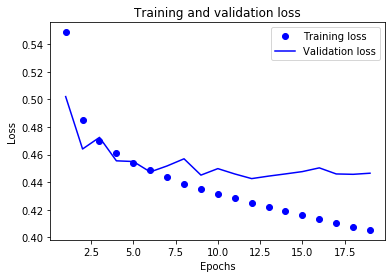

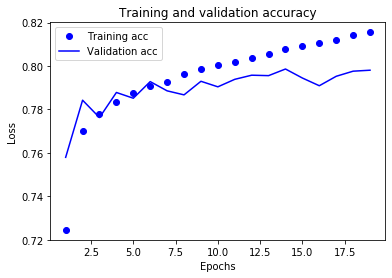

In [20]:
# Loss plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Evaluating model on test data**

In [21]:
test_label = np.asarray(test_label)
test_embedding_matrix = get_embeddings(test_data)
results = model.evaluate(test_embedding_matrix, test_label)
print("Loss: ", results[0])
print("Accuracy: ", results[1])

0
359/359 [==============================] - ETA:  - 0s 125us/step
Loss:  0.4374970794554208
Accuracy:  0.807799442896936


**Results**

We trained our network on 140.000 samples (120.000 training and 20.000 validation samples) and used the word embedding vectors obtained by ConceptNet. Unfortunately, due to hardware limitations, this is less than a 10th of the available training data. However, as we tested the model with multiple random subsets of the 1.6M samples we achieved accuracies in-between 78%-82%, and therefore perform as good as several state-of-the-art approaches [Go et al.](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf), [Ebert et al.](https://www.aclweb.org/anthology/W15-2915). Accuracy and loss improve until epoch 6-10 and more or less stagnate until epoch 20.